In [1]:
import pandas as pd

# Load the CSV file
df = pd.read_csv(r"C:\Users\HP\Desktop\DATA_ANALYTICS\column_variations2.csv")

# Display the first few rows
print(df.head())


     base_name    variation
0  customer_id       custid
1  customer_id   CustomerID
2  customer_id      cust_id
3  customer_id  customer-id
4  customer_id       CustID


In [2]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

In [3]:
# Use TF-IDF to convert text variations into numerical features
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 3))  # Character-level bigrams and trigrams
X = vectorizer.fit_transform(df["variation"])
y = df["base_name"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

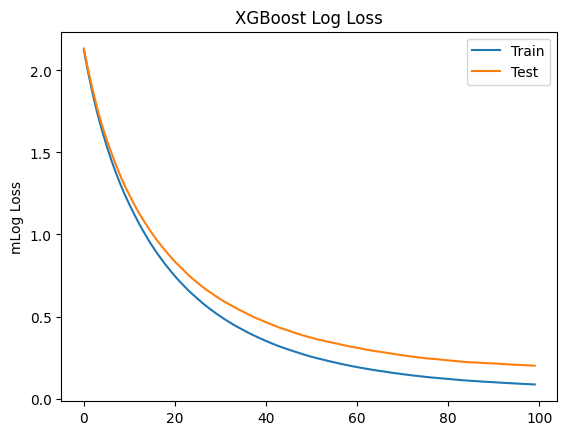


Model Accuracy: 96.25%

Classification Report:
              precision    recall  f1-score   support

     address       0.82      1.00      0.90         9
        city       1.00      0.88      0.93         8
     country       1.00      0.88      0.93         8
 customer_id       1.00      1.00      1.00         8
       email       1.00      0.89      0.94         9
  first_name       0.88      1.00      0.93         7
   last_name       1.00      1.00      1.00         7
phone_number       1.00      1.00      1.00         8
       state       1.00      1.00      1.00         8
    zip_code       1.00      1.00      1.00         8

    accuracy                           0.96        80
   macro avg       0.97      0.96      0.96        80
weighted avg       0.97      0.96      0.96        80



In [20]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target labels (y_train and y_test)
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


eval_set = [(X_train, y_train_encoded), (X_test, y_test_encoded)]
eval_metric = ["merror", "mlogloss"]

# Initialize the XGBoost Classifier
model_xgb = XGBClassifier(
    n_estimators=100,       # Number of boosting rounds (trees)
    learning_rate=0.05,      # Step size shrinkage to prevent overfitting
    max_depth=4,            # Maximum depth of each tree
    subsample=0.8,          # Fraction of samples to use for each tree
    colsample_bytree=0.8,   # Fraction of features to use for each tree
    random_state=42,        # For reproducibility
    eval_metric=eval_metric# Metric for multi-class classification
)

# Train the model with encoded labels
model_xgb.fit(X_train,
              y_train_encoded,
              eval_set=eval_set,
              verbose=False)

# Predict on the test set
y_pred_encoded = model_xgb.predict(X_test)

# Decode the predicted labels back to original string labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Save the XGBoost model
#joblib.dump(model_xgb, 'xgboost_schema_mapper.pkl')

# Save the label encoder
#joblib.dump(label_encoder, 'label_encoder.pkl')

# Save the vectorizer
#joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')



results=model_xgb.evals_result()

epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mLog Loss')
plt.title('XGBoost Log Loss')
plt.show()


# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(
    estimator=XGBClassifier(objective='multi:softprob', num_class=8),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1
)

grid.fit(X_train, y_train_encoded)
print(grid.best_params_)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}


Random Forest Classifier
Accuracy: {0.9625} Report: {'              precision    recall  f1-score   support\n\n     address       0.90      1.00      0.95         9\n        city       1.00      0.88      0.93         8\n     country       1.00      0.88      0.93         8\n customer_id       1.00      1.00      1.00         8\n       email       1.00      0.89      0.94         9\n  first_name       0.78      1.00      0.88         7\n   last_name       1.00      1.00      1.00         7\nphone_number       1.00      1.00      1.00         8\n       state       1.00      1.00      1.00         8\n    zip_code       1.00      1.00      1.00         8\n\n    accuracy                           0.96        80\n   macro avg       0.97      0.96      0.96        80\nweighted avg       0.97      0.96      0.96        80\n'}
Precision: 0.97
Recall: 0.96
F1-Score: 0.96
Log Loss: 0.1529
ROC-AUC Score: 0.9998

Classification Report:
              precision    recall  f1-score   support

     ad

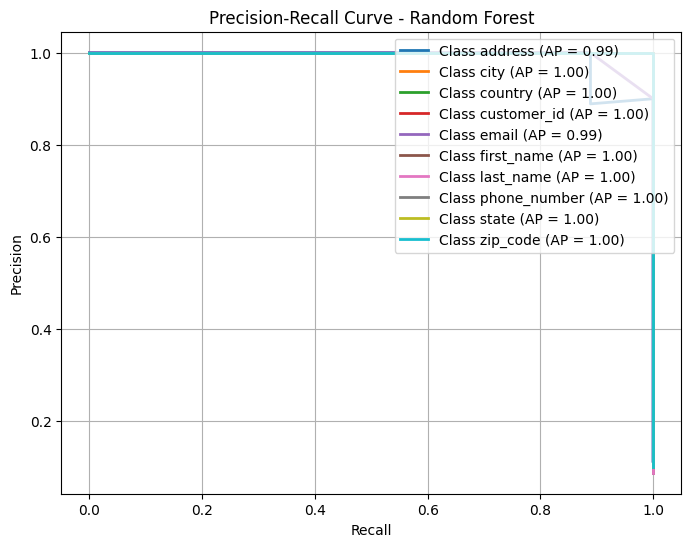

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import precision_recall_curve, average_precision_score


model2=RandomForestClassifier(random_state=42)
model2.fit(X_train, y_train_encoded)
y_pred_encoded = model2.predict(X_test)

# Decode the predicted labels back to original string labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Random Forest Classifier")
print(f"Accuracy:" ,{accuracy}, "Report:", {report})

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    log_loss
)
prec=precision_score(y_test, y_pred,average='weighted')
rec=recall_score(y_test, y_pred,average='weighted')
f1=f1_score(y_test, y_pred,average='weighted')

# Probability predictions (for log loss and ROC-AUC)
y_pred_proba = model2.predict_proba(X_test)
logloss = log_loss(y_test, y_pred_proba)
# ROC-AUC (One-vs-Rest for multi-class)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')


print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Log Loss: {logloss:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")


# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Binarize the true labels
y_test_bin = label_binarize(y_test, classes=label_encoder.classes_)

# Get probability scores
y_score = model2.predict_proba(X_test)

precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(label_encoder.classes_)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

# Plot PR curve for each class
plt.figure(figsize=(8,6))
for i in range(len(label_encoder.classes_)):
    plt.plot(recall[i], precision[i], lw=2, label=f"Class {label_encoder.classes_[i]} (AP = {average_precision[i]:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Random Forest")
plt.legend(loc="upper right")
plt.grid()
plt.show()



In [16]:

model3=SVC(kernel='linear', probability=True, random_state=42)
model3.fit(X_train, y_train_encoded)
y_pred_encoded = model3.predict(X_test)

# Decode the predicted labels back to original string labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("SVM")
print(f"Accuracy:" ,{accuracy}, "Report:", {report})

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    log_loss
)
prec=precision_score(y_test, y_pred,average='weighted')
rec=recall_score(y_test, y_pred,average='weighted')
f1=f1_score(y_test, y_pred,average='weighted')

# Probability predictions (for log loss and ROC-AUC)
y_pred_proba = model3.predict_proba(X_test)
logloss = log_loss(y_test, y_pred_proba)
# ROC-AUC (One-vs-Rest for multi-class)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')


print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Log Loss: {logloss:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")


# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

SVM
Accuracy: {0.9875} Report: {'              precision    recall  f1-score   support\n\n     address       0.90      1.00      0.95         9\n        city       1.00      1.00      1.00         8\n     country       1.00      1.00      1.00         8\n customer_id       1.00      1.00      1.00         8\n       email       1.00      0.89      0.94         9\n  first_name       1.00      1.00      1.00         7\n   last_name       1.00      1.00      1.00         7\nphone_number       1.00      1.00      1.00         8\n       state       1.00      1.00      1.00         8\n    zip_code       1.00      1.00      1.00         8\n\n    accuracy                           0.99        80\n   macro avg       0.99      0.99      0.99        80\nweighted avg       0.99      0.99      0.99        80\n'}
Precision: 0.99
Recall: 0.99
F1-Score: 0.99
Log Loss: 0.2451
ROC-AUC Score: 0.9997

Classification Report:
              precision    recall  f1-score   support

     address       0.90     

In [12]:
model4= LogisticRegression(max_iter=1000, random_state=42)
model4.fit(X_train, y_train_encoded)
y_pred_encoded = model4.predict(X_test)

# Decode the predicted labels back to original string labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Logistic Regression")
print(f"Accuracy:" ,{accuracy}, "Report:", {report})

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    log_loss
)
prec=precision_score(y_test, y_pred,average='weighted')
rec=recall_score(y_test, y_pred,average='weighted')
f1=f1_score(y_test, y_pred,average='weighted')

# Probability predictions (for log loss and ROC-AUC)
y_pred_proba = model4.predict_proba(X_test)
logloss = log_loss(y_test, y_pred_proba)
# ROC-AUC (One-vs-Rest for multi-class)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')


print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Log Loss: {logloss:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")


# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))


Logistic Regression
Accuracy: {0.9875} Report: {'              precision    recall  f1-score   support\n\n     address       0.90      1.00      0.95         9\n        city       1.00      1.00      1.00         8\n     country       1.00      1.00      1.00         8\n customer_id       1.00      1.00      1.00         8\n       email       1.00      0.89      0.94         9\n  first_name       1.00      1.00      1.00         7\n   last_name       1.00      1.00      1.00         7\nphone_number       1.00      1.00      1.00         8\n       state       1.00      1.00      1.00         8\n    zip_code       1.00      1.00      1.00         8\n\n    accuracy                           0.99        80\n   macro avg       0.99      0.99      0.99        80\nweighted avg       0.99      0.99      0.99        80\n'}
Precision: 0.99
Recall: 0.99
F1-Score: 0.99
Log Loss: 0.5041
ROC-AUC Score: 0.9995

Classification Report:
              precision    recall  f1-score   support

     address

In [13]:
model5= MultinomialNB()
model5.fit(X_train, y_train_encoded)
y_pred_encoded = model5.predict(X_test)

# Decode the predicted labels back to original string labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Naive Bayes")
print(f"Accuracy:" ,{accuracy}, "Report:", {report})

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    log_loss
)
prec=precision_score(y_test, y_pred,average='weighted')
rec=recall_score(y_test, y_pred,average='weighted')
f1=f1_score(y_test, y_pred,average='weighted')

# Probability predictions (for log loss and ROC-AUC)
y_pred_proba = model5.predict_proba(X_test)
logloss = log_loss(y_test, y_pred_proba)
# ROC-AUC (One-vs-Rest for multi-class)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')


print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Log Loss: {logloss:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")


# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Naive Bayes
Accuracy: {0.9875} Report: {'              precision    recall  f1-score   support\n\n     address       0.90      1.00      0.95         9\n        city       1.00      1.00      1.00         8\n     country       1.00      1.00      1.00         8\n customer_id       1.00      1.00      1.00         8\n       email       1.00      0.89      0.94         9\n  first_name       1.00      1.00      1.00         7\n   last_name       1.00      1.00      1.00         7\nphone_number       1.00      1.00      1.00         8\n       state       1.00      1.00      1.00         8\n    zip_code       1.00      1.00      1.00         8\n\n    accuracy                           0.99        80\n   macro avg       0.99      0.99      0.99        80\nweighted avg       0.99      0.99      0.99        80\n'}
Precision: 0.99
Recall: 0.99
F1-Score: 0.99
Log Loss: 0.3582
ROC-AUC Score: 0.9991

Classification Report:
              precision    recall  f1-score   support

     address       0

In [9]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    log_loss
)
prec=precision_score(y_test, y_pred,average='weighted')
rec=recall_score(y_test, y_pred,average='weighted')
f1=f1_score(y_test, y_pred,average='weighted')

# Probability predictions (for log loss and ROC-AUC)
y_pred_proba = model_xgb.predict_proba(X_test)
logloss = log_loss(y_test, y_pred_proba)
# ROC-AUC (One-vs-Rest for multi-class)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')

print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Log Loss: {logloss:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

Precision: 0.97
Recall: 0.96
F1-Score: 0.96
Log Loss: 0.1692
ROC-AUC Score: 0.9996


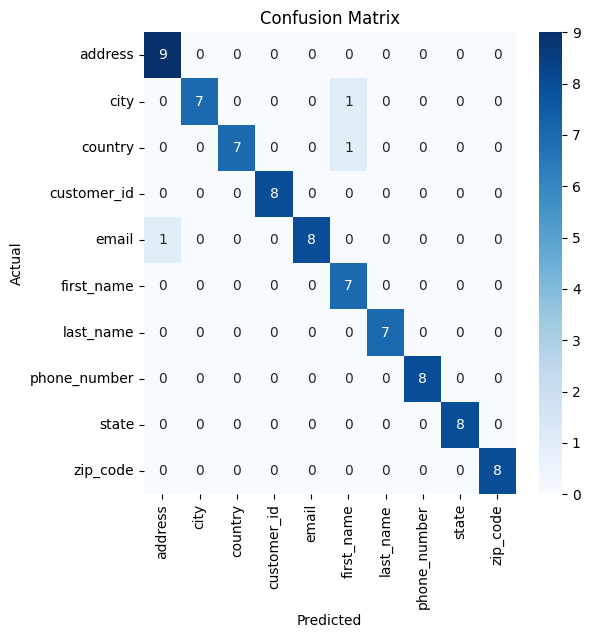

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

#this is for XGBoost
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [2]:
# Now for the MySQL connection and mapping
import mysql.connector
import pandas as pd
from dotenv import load_dotenv
import os
import joblib

def configure():
    load_dotenv()

def map_columns_from_db():
    configure()
    # Load saved artifacts
    model = joblib.load('xgboost_schema_mapper.pkl')
    label_encoder = joblib.load('label_encoder.pkl')
    vectorizer = joblib.load('tfidf_vectorizer.pkl')

    # Connect to MySQL
    conn = mysql.connector.connect(
        host="localhost",
        user="root",
        password=os.getenv('pwd'),
        database="data_minor"
    )
    
    # Fetch raw column names from MySQL table
    cursor = conn.cursor()
    cursor.execute("SHOW COLUMNS FROM Locations")
    raw_columns = [col[0] for col in cursor.fetchall()]
    
    # Preprocess and predict
    X_new = vectorizer.transform(raw_columns)
    predictions = model.predict(X_new)
    standardized = label_encoder.inverse_transform(predictions)
    
    # Create mapping dataframe
    mapping_df = pd.DataFrame({
        'raw_column': raw_columns,
        'standard_name': standardized
    })
    
    # Save mapping to MySQL
    #mapping_df.to_sql('column_mappings', con=conn, if_exists='replace', index=False)
    
    # Close connections
    cursor.close()
    conn.close()
    
    return mapping_df

# Execute the mapping
result = map_columns_from_db()
print(result.head())


    raw_column standard_name
0  location_id   customer_id
1    client_id   customer_id
2       region       address
3  postal_code      zip_code
4      country       country
